```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. https://realpython.com/logistic-regression-python/
2. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
3. https://www.scikit-yb.org/en/latest/quickstart.html
4. https://github.com/parrt/dtreeviz

```

# Classification

Classification is a supervised learning mechanism for labeling a sample based on the features. Supervised learning means that we have labels for classification or numbers for regression that the algorithm should learn.

Sklearn implements many common and useful models. We will also see some that are not in sklearn, but implement the sklearn interface. Because they follow the same interface, it is easy to try different families of models and see how well they perform.

In sklearn, we create a model instance and call the `.fit` method on it with the training data and training labels. We can now call the `.predict` method (or the `.predict_prob`a or the `.predict_log_proba` methods) with the fitted model. To evaluate the model, we use the `.score` with testing data and testing labels.

The bigger challenge is usually arranging data in a form that will work with sklearn. The data (`X`) should be an (m by n) numpy array (or pandas DataFrame) with m rows of sample data each with n features (columns). The label (`y`) is a vector (or pandas series) of size m with a value (class) for each sample.

The `.score` method returns the mean accuracy, which by itself might not be sufficient to evaluate a classifier. We will see other evaluation metrics.

We will look at many models and discuss their efficiency, the preprocessing techniques they require, how to prevent overfitting, and if the model supports intuitive interpretation of results.

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset,
    add_prefix_to_list_items
)

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [6]:
# The Sonar Dataset involves the prediction of whether or not an object is a mine or a rock given the strength of sonar returns at different angles.
# It is a binary (2-class) classification problem. The number of observations for each class is not balanced. 
# There are 208 observations with 60 input variables and 1 output variable. The variable names are as follows:
# Sonar returns at different angles
# Class (M for mine and R for rock)

df = get_dataset('sonar')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [7]:
# Missing values?
df.isnull().mean().value_counts()

0.0    61
dtype: int64

In [8]:
y = df[[60]]
X = df.drop(columns=60)

In [9]:
# Column names should start with a letter, otherwise some libraries throw errors
y.columns = add_prefix_to_list_items('t', y) # target (dependent variable)
X.columns = add_prefix_to_list_items('v', X) # independent variables

In [10]:
X.columns

Index(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40',
       'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50',
       'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59'],
      dtype='object')

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
y_train[:10]

,t60
53,R
21,R
75,R
204,M
67,R
97,M
132,M
92,R
100,M
128,M


In [14]:
y_train.values[:10]

array([['R'],
       ['R'],
       ['R'],
       ['M'],
       ['R'],
       ['M'],
       ['M'],
       ['R'],
       ['M'],
       ['M']], dtype=object)

In [15]:
y_train.values.ravel()[:10]

array(['R', 'R', 'R', 'M', 'R', 'M', 'M', 'R', 'M', 'M'], dtype=object)

## Logistic Regression

[Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) estimates probabilities by using a logistic function. This has been the standard classification model for most sciences.

The following are some model characteristics that we will include for each model:
- **Runtime efficiency:** Can use `n_jobs` if not using 'liblinear' solver.
- **Preprocess data:** If solver is set to 'sag' or 'saga', standardize so that convergence works. Can handle sparse input.
- **Prevent overfitting:** The `C` parameter controls regularization. Lower C is more regularization, higher means less. Can specify penalty to 'l1' or 'l2' (the default).
- **Interpret results:** The `.coef_` attribute of the fitted model shows the decision function coefficients. A change in x one unit changes the log odds ratio by the coefficient. The `.intercept_` attribute is the inverse log odds of the baseline condition.

In [16]:
from sklearn.linear_model import LogisticRegression

# .values will give the values in an array. (shape: (n,1)
# .ravel will convert that array shape to (n, )

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(random_state=42)

In [17]:
# Accuracy
lr.score(X_test, y_test)

0.7619047619047619

In [18]:
lr.predict(X.iloc[[0]])

array(['R'], dtype=object)

In [19]:
lr.predict_proba(X.iloc[[0]])

array([[0.47480327, 0.52519673]])

In [20]:
lr.predict_log_proba(X.iloc[[0]])

array([[-0.74485472, -0.64398237]])

In [21]:
lr.decision_function(X.iloc[[0]])

array([0.10087235])

The intercept is the log odds of the baseline condition. We can convert it back to a percent accuracy (proportion). Using the `inverse logit` function.

In [22]:
lr.intercept_

array([2.26917919])

In [23]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

inv_logit(lr.intercept_)

array([0.9062921])

We can inspect the coefficients. The inverse logit of the coefficients gives the proportion of the positive cases.

In [24]:
cols = X.columns
for col, val in sorted(zip(cols, lr.coef_[0]), key=lambda x: x[1], reverse=True,):
    print(f"{col:10}{val:10.3f} {inv_logit(val):10.3f}")

v35            1.014      0.734
v30            0.829      0.696
v15            0.674      0.662
v36            0.672      0.662
v16            0.587      0.643
v25            0.547      0.633
v33            0.517      0.626
v14            0.409      0.601
v34            0.249      0.562
v6             0.248      0.562
v24            0.224      0.556
v5             0.166      0.541
v7             0.153      0.538
v39            0.142      0.536
v29            0.113      0.528
v17            0.107      0.527
v26            0.083      0.521
v32            0.081      0.520
v23            0.019      0.505
v54           -0.010      0.497
v56           -0.013      0.497
v59           -0.022      0.494
v58           -0.047      0.488
v55           -0.050      0.487
v52           -0.062      0.485
v57           -0.064      0.484
v53           -0.076      0.481
v49           -0.077      0.481
v13           -0.082      0.479
v28           -0.112      0.472
v51           -0.113      0.472
v50     

Yellowbrick can also visualize the coefficients. This visualizer has a relative=True parameter that makes the largest value be 100 (or -100), and the others are the percentages of that.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/local/lib/python3.8/dist-packages/yellowbrick/model_selection/importances.py:190: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
fin

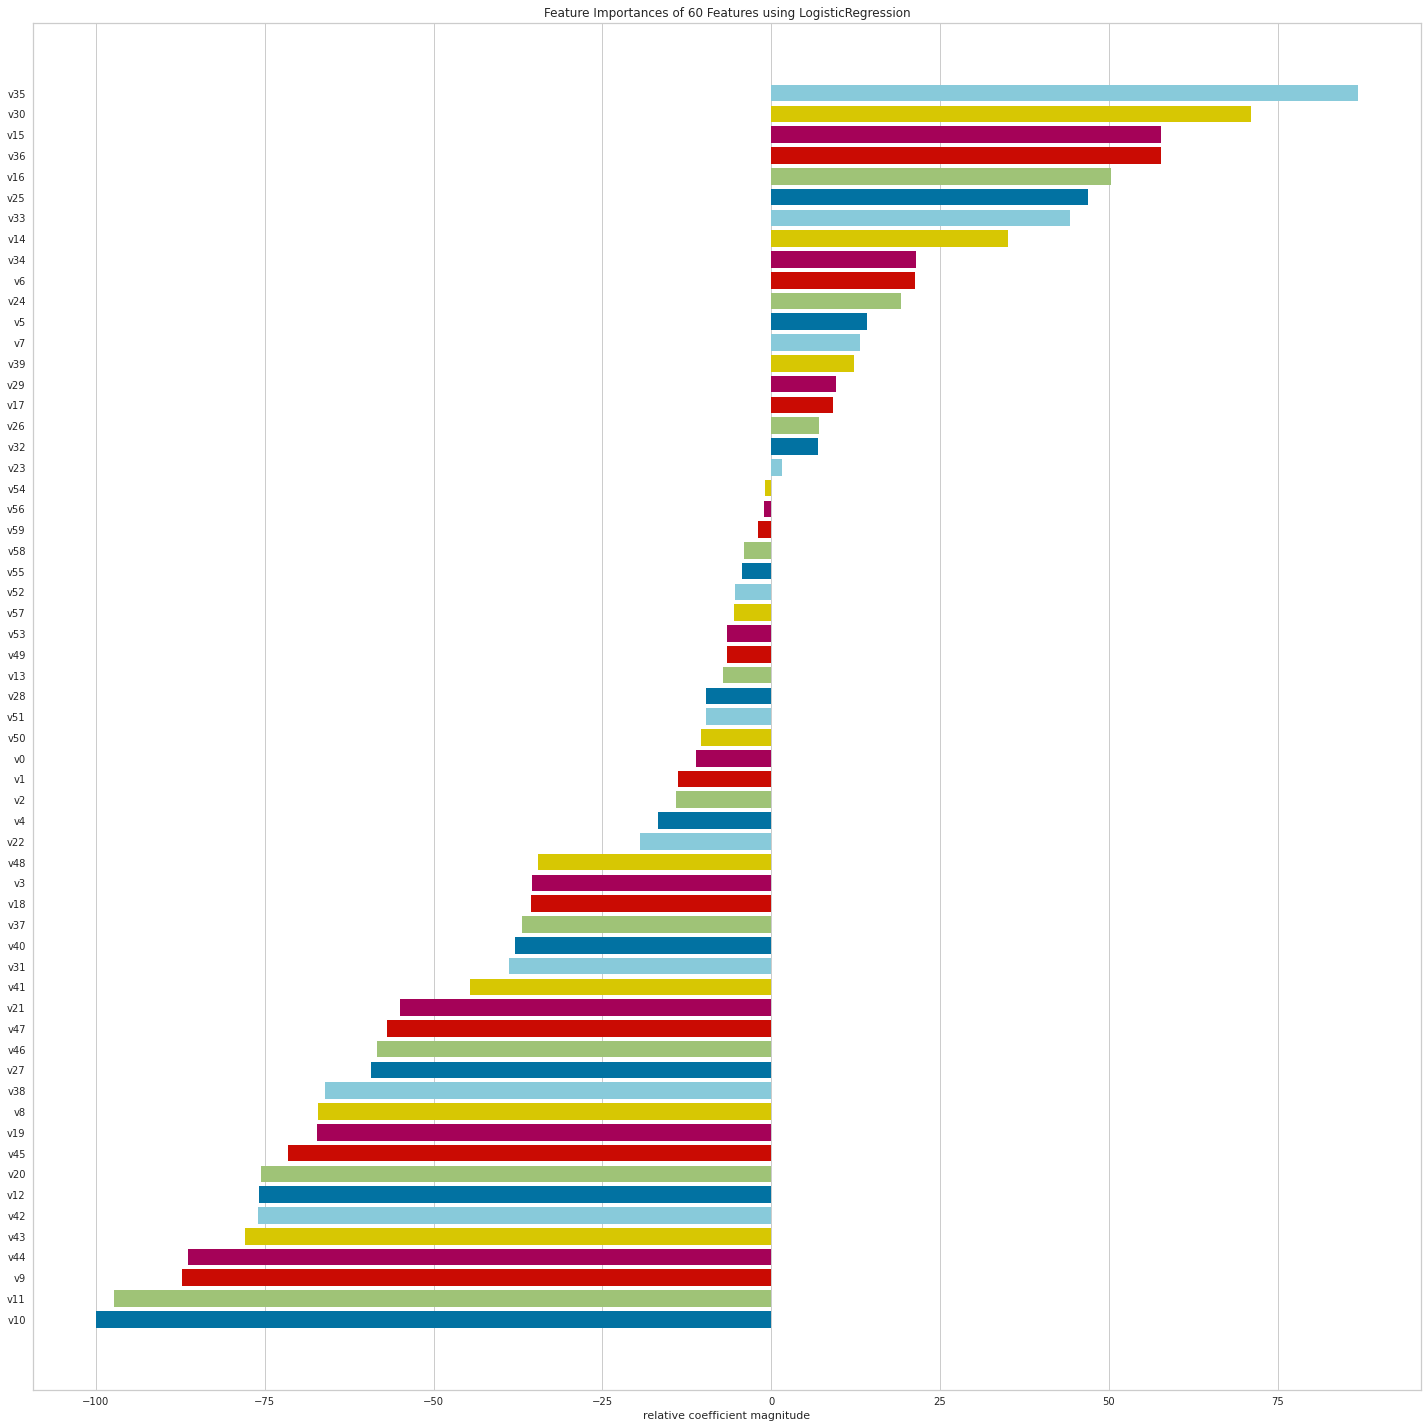

In [26]:
from yellowbrick.features import FeatureImportances

fig, ax = plt.subplots(figsize=(20, 20))
fi_viz = FeatureImportances(lr)
fi_viz.fit(X, y)
fi_viz.poof()
fig.savefig("images/classification_logistic_regression.png", dpi=300)

## Naive Bayes
[Naive Bayes](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) is a probabilistic classifier that assumes independence between the features of the data. It is popular for text classification applications, such as catching spam. One advantage of this model is that because it assumes feature independence, it can train a model with a small number of samples. (A downside is that it can’t capture the interactions between features.) This simple model can also work with data that has many features. As such, it serves as a good baseline model.

There are three classes in sklearn: GaussianNB, MultinomialNB, and BernoulliNB. The first assumes a Gaussian distribution (continuous features with a normal distribution), the second is for discrete occurrence counts, and the third is for discrete Boolean features.

This model has the following properties:
- **Runtime efficiency:** Training O(Nd), where N is the number of training examples and d is dimensionality. Testing O(cd), where c is the number of classes.
- **Preprocess data:** Assumes that data is independent. Should perform better after removing colinear columns. For continuous numerical data, might be good to bin data. Gaussian assumes normal distribution, and you might need to transform data to convert to normal distribution.
- **Prevent overfitting:** Exhibits high bias and low variance (ensembles won’t reduce variance).
- **Interpret results:** Percentage is the likelihood that a sample belongs to a class based on priors.

These models are susceptible to the `zero probability problem`. If you try to classify a new sample that has no training data, it will have a zero probability. One solution is to use Laplace smoothing. Sklearn controls this with the alpha parameter, which defaults to 1 and enables smoothing on the MultinomialNB and BernoulliNB models.

In [27]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())

GaussianNB()

In [28]:
nb.score(X_test, y_test)

0.6190476190476191

In [29]:
nb.predict(X.iloc[[0]])

array(['R'], dtype='<U1')

In [30]:
nb.predict_proba(X.iloc[[0]])

array([[0.06061917, 0.93938083]])

In [31]:
nb.predict_log_proba(X.iloc[[0]])

array([[-2.80314402, -0.06253432]])

## Support Vector Machine
A [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html#classification) is an algorithm that tries to fit a line (or plane or hyperplane) between the different classes that maximizes the distance from the line to the points of the classes. In this way it tries to find a robust separation between the classes. The support vectors are the points of the edge of the dividing hyperplane.

There are a few different SVM implementations in sklearn. SVC wraps the libsvm library, while LinearSVC wraps the liblinear library. There is also the linear_model.SGDClassifier, which implements SVM when using the default loss parameter. This chapter will describe the first implementation.

SVM generally performs well and can support linear spaces or nonlinear spaces by using a `kernel trick`. The kernel trick is the idea that we can create a decision boundary in a new dimension by minimizing a formula that is easier to calculate than actually mapping the points to the new dimension. The default kernel is the Radial Basis Function ('rbf'), which is controlled by the gamma parameter and can map an input space into a high dimensional space.

SVMs have the following properties:
- **Runtime efficiency:** The scikit-learn implementation is O(n⁴), so it can be hard to scale to large sizes. Using a linear kernel or the LinearSVC model can improve the runtime performance at perhaps the cost of accuracy. Upping the cache_size parameter can bring that down to O(n³).
- **Preprocess data:** The algorithm is not scale invariant. Standardizing the data is highly recommended.
- **Prevent overfitting:** The C (penalty parameter) controls regularization. A smaller value allows for a smaller margin in the hyperplane. A higher value for gamma will tend to overfit the training data. The LinearSVC model supports a loss and penalty parameter to support regularization.
- **Interpret results:** Inspect .support_vectors_, though these are hard to explain. With linear kernels, you can inspect .coef_.

To get probability, use `probability=True`, which will slow down fitting of the model.

In [32]:
from sklearn.svm import SVC

svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train.values.ravel())

SVC(probability=True, random_state=42)

In [33]:
svc.score(X_test, y_test)

0.8095238095238095

In [34]:
svc.predict(X.iloc[[0]])

array(['R'], dtype=object)

In [35]:
svc.predict_proba(X.iloc[[0]])

array([[0.3573829, 0.6426171]])

In [36]:
svc.predict_log_proba(X.iloc[[0]])

array([[-1.02894752, -0.44220623]])

## K-Nearest Neighbor
The [K-Nearest Neighbor (KNN)](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) algorithm classifies based on distance to some number (k) of training samples. The algorithm family is called instance-based learning as there are no parameters to learn. This model assumes that distance is sufficient for inference; otherwise it makes no assumptions about the underlying data or its distributions.

The tricky part is selecting the appropriate `k` value. Also, the curse of dimensionality can hamper distance metrics as there is little difference in high dimensions between nearest and farthest neighbor.

Nearest neighbor models have the following properties:
- **Runtime efficiency:** Training O(1), but need to store data. Testing O(Nd) where N is the number of training examples and d is dimensionality.
- **Preprocess data:** Yes, distance-based calculations perform better when standardized.
- **Prevent overfitting:** Raise n_neighbors. Change p for L1 or L2 metric.
- **Interpret results:** Interpret the k-nearest neighbors to the sample (using the .kneighbors method). Those neighbors (if you can explain them) explain your result.

If `k` is an even number and the neighbors are split, the result depends on the order of the training data.

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [38]:
knc.score(X_test, y_test)

0.7301587301587301

In [39]:
knc.predict(X.iloc[[0]])

array(['M'], dtype=object)

In [40]:
knc.predict_proba(X.iloc[[0]])

array([[0.6, 0.4]])

## Decision Tree
A [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree-classification) is like going to a doctor who asks a series of questions to determine the cause of your symptoms. We can use a process to create a decision tree and have a series of questions to predict a target class. The advantages of this model include support for nonnumeric data (in some implementations), little data preparation (no need for scaling), support for dealing with nonlinear relationships, feature importances are revealed, and it is easy to explain.

The default algorithm used for creation is called the classification and regression tree (`CART`). It uses the Gini impurity or index measure to construct decisions. This is done by looping over the features and finding the value that gives the lowest probability of misclassifying.

The default values will lead to a fully grown (read overfit) tree. Use a mechanism such as `max_dept`h and `cross-validation` to control for this.

Decision trees have the following properties:
- **Runtime efficiency:** For creation, loop over each of the m features, and sort all n samples, O(mn log n). For predicting, you walk the tree, O( height).
- **Preprocess data:** Scaling is not necessary. Need to get rid of missing values and convert to numeric.
- **Prevent overfitting:** Set max_depth to a lower number, raise min_impurity_decrease.
- **Interpret results:** Can step through the tree of choices. Because there are steps, a tree is bad at dealing with linear relationships (a small change in a number can go down a different path). The tree is also highly dependent on the training data. A small change can change the whole tree.

In [41]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=3, random_state=42)

In [42]:
dt.score(X_test, y_test)

0.7142857142857143

In [43]:
dt.predict(X.iloc[[0]])

array(['M'], dtype=object)

In [44]:
dt.predict_proba(X.iloc[[0]])

array([[0.8852459, 0.1147541]])

In [45]:
dt.predict_log_proba(X.iloc[[0]])

array([[-0.12188982, -2.16496372]])

In [48]:
# Viewing tree
import pydotplus

from io import StringIO
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(dt,
                     out_file=dot_data,
                     feature_names=X.columns,
                     class_names=None,
                     filled=True,
                    )
g = pydotplus.graph_from_dot_data(dot_data.getvalue())
g.write_png("images/classification_tree1.png")

True

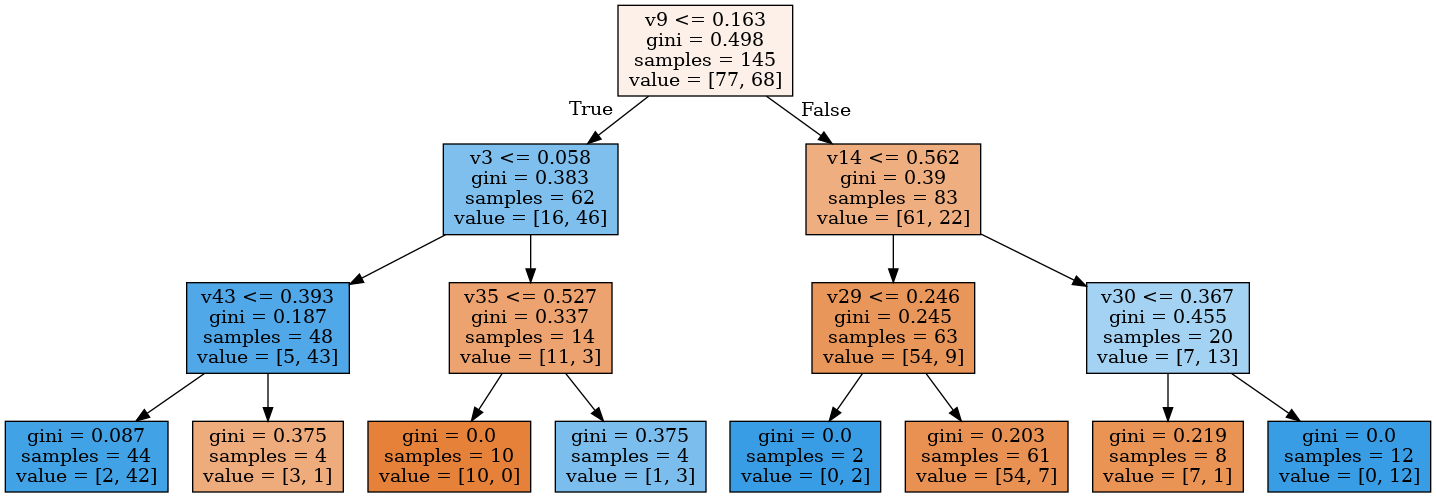

In [49]:
from IPython.display import Image
Image(g.create_png())

In [53]:
from dtreeviz.trees import *

# All collumn(s) should have names starting with a letter...
viz = dtreeviz(dt, 
               X, 
               y,
               target_name='t',
               feature_names=X.columns, 
               class_names=['R', 'M']  # need class_names for classifier
              )  
              
viz.view() 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [54]:
# Feature importance showing Gini importance (reduction of error by using that feature)
for col, val in sorted(zip(X.columns, dt.feature_importances_),
                       key=lambda x: x[1],
                       reverse=True,
                      )[:5]:
    print(f"{col:10}{val:10.3f}")

v9             0.315
v3             0.196
v14            0.152
v30            0.143
v43            0.071


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


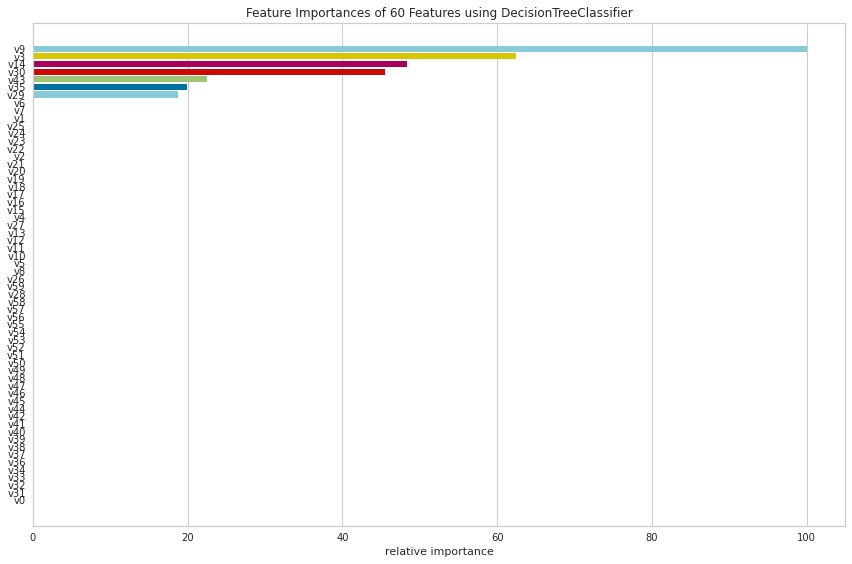

In [55]:
# Visualize feature importance
from yellowbrick.features import FeatureImportances

fig, ax = plt.subplots(figsize=(12, 8))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X, y)
fi_viz.poof()
fig.savefig("images/classification_tree2.png", dpi=300)

## Random Forest
A [random forest](https://scikit-learn.org/stable/modules/ensemble.html#forest) is an ensemble of decision trees. It uses `bagging` to correct the tendency of decision trees to overfit. By creating many trees trained on random subsamples of the samples and random features of the data, the variance is lowered.

Because they train on subsamples of the data, random forests can evaluate [out-of-bag (OOB) error](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and evaluate performance. They can also track feature importance by averaging the feature importance over all of the trees.

The intuition for understanding `bagging` comes from a 1785 essay by Marquis de Condorcet. The essence is that if you are creating a jury, you should add anyone who has a greater than 50% chance of delivering the correct verdict and then average their decisions. Every time you add another member (and their selection process is independent of the others), you will get a better result.

The idea with random forests is to create a “forest” of decision trees trained on different columns of the training data. If each tree has a better than 50% chance of correct classification, you should incorporate its prediction. The random forest has been an excellent tool for both classification and regression, though it has recently fallen out of favor for `gradient-boosted` trees.

It has the following properties:
- **Runtime efficiency:** Need to create j random trees. This can be done in parallel using n_jobs. Complexity for each tree is O(mn log n), where n is the number of samples and m is the number of features. For creation, loop over each of the m features, and sort all n samples, O(mn log n). For predicting, walk the tree O( height).
- **Preprocess data:** Not necessary.
- **Prevent overfitting:** Add more trees (n_estimators). Use lower max_depth.
- **Interpret results:** Supports feature importance, but we don’t have a single decision tree that we can walk through. Can inspect single trees from the ensemble.

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [57]:
rf.score(X_test, y_test)

0.8571428571428571

In [58]:
rf.predict(X.iloc[[0]])

array(['M'], dtype=object)

In [59]:
rf.predict_proba(X.iloc[[0]])

array([[0.65, 0.35]])

In [60]:
rf.predict_log_proba(X.iloc[[0]])

array([[-0.43078292, -1.04982212]])

In [61]:
# Feature importance showing Gini importance (reduction of error by using that feature)
for col, val in sorted(zip(X.columns, rf.feature_importances_),
                       key=lambda x: x[1],
                       reverse=True,
                      )[:5]:
    print(f"{col:10}{val:10.3f}")

v9             0.048
v8             0.042
v10            0.042
v11            0.041
v12            0.034


The random forest classifier computes the feature importance by determining the mean decrease in impurity for each feature (also known as `Gini` importance). Features that reduce uncertainty in classification receive higher scores.

These numbers might be off if features vary in scale or cardinality of categorical columns. A more reliable score is `permutation importance` (where each column has its values permuted and the drop in accuracy is measured). An even more reliable mechanism is `drop column importance` (where each column is dropped and the model is re-evaluated), but sadly this requires creating a new model for each column that is dropped. See the importances function in the `rfpimp` package:

In [63]:
import rfpimp

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rfpimp.importances(rf, X_test, y_test).Importance

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
<ipython-input-63-96f35af76355>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Feature
v20    0.047619
v13    0.031746
v22    0.031746
v19    0.031746
v9     0.031746
v50    0.031746
v51    0.031746
v18    0.015873
v1     0.015873
v29    0.015873
v26    0.015873
v48    0.015873
v36    0.015873
v11    0.015873
v10    0.015873
v8     0.015873
v56    0.015873
v3     0.015873
v57    0.015873
v53    0.000000
v43    0.000000
v38    0.000000
v39    0.000000
v40    0.000000
v41    0.000000
v42    0.000000
v58    0.000000
v45    0.000000
v44    0.000000
v52    0.000000
v46    0.000000
v47    0.000000
v55    0.000000
v54    0.000000
v37    0.000000
v49    0.000000
v0     0.000000
v30    0.000000
v35    0.000000
v34    0.000000
v2     0.000000
v4     0.000000
v5     0.000000
v6     0.000000
v7     0.000000
v12    0.000000
v14    0.000000
v15    0.000000
v16    0.000000
v17    0.000000
v21    0.000000
v23    0.000000
v24    0.000000
v25    0.000000
v27    0.000000
v28    0.000000
v31    0.000000
v32    0.000000
v33    0.000000
v59    0.000000
Name: Importance, dtype: float64

## XGBoost
Although sklearn has a GradientBoostedClassifier, it is better to use a third-party implementation that uses `extreme boosting`. These tend to provide better results.

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a popular library outside of scikit-learn. It creates a weak tree and then “boosts” the subsequent trees to reduce the residual errors. It tries to capture and address any patterns in the errors until they appear to be random.

XGBoost has the following properties:
- **Runtime efficiency:** XGBoost is parallelizeable. Use the n_jobs option to indicate the number of CPUs. Use GPU for even better performance.
- **Preprocess data:** No scaling necessary with tree models. Need to encode categorical data.
- **Prevent overfitting:** The early_stopping_rounds=N parameter can be set to stop training if there is no improvement after N rounds. L1 and L2 regularization are controlled by reg_alpha and reg_lambda, respectively. Higher numbers are more conservative.
- **Interpret results:** Has feature importance.

XGBoost has an extra parameter for the `.fit` method. The `early_stopping_rounds` parameter can be combined with the `eval_set` parameter to tell XGBoost to stop creating trees if the evaluation metric has not improved after that many boosting rounds. The `eval_metric` can also be set to one of the following: 'rmse', 'mae', 'logloss', 'error' (default), 'auc', 'aucpr', as well as a custom function.

In [64]:
import xgboost as xgb

xgb_class = xgb.XGBClassifier(random_state=42)

xgb_class.fit(X_train,
              y_train.values.ravel(),
              early_stopping_rounds=10,
              eval_set=[(X_test, y_test)],
             )

[0]	validation_0-error:0.19048
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.28571
[2]	validation_0-error:0.25397
[3]	validation_0-error:0.23810
[4]	validation_0-error:0.22222
[5]	validation_0-error:0.22222
[6]	validation_0-error:0.22222
[7]	validation_0-error:0.22222
[8]	validation_0-error:0.23810
[9]	validation_0-error:0.19048
[10]	validation_0-error:0.20635
Stopping. Best iteration:
[0]	validation_0-error:0.19048



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
xgb_class.score(X_test, y_test)

0.8095238095238095

In [66]:
xgb_class.predict(X.iloc[[0]])

array(['M'], dtype=object)

In [67]:
xgb_class.predict_proba(X.iloc[[0]])

array([[0.59868765, 0.40131235]], dtype=float32)

In [68]:
# Feature importance is the average gain across all the nodes where the feature is used
for col, val in sorted(zip(X.columns, xgb_class.feature_importances_,),
                       reverse=True,
                      )[:5]:
    print(f"{col:10}{val:10.3f}")

v9             0.123
v8             0.042
v7             0.024
v6             0.009
v59            0.000


XGBoost can plot the feature importance. It has an `importance_type` parameter. The default value is "weight", which is the number of times a feature appears in a tree. It can also be "gain", which shows the average gain when the feature is used, or "cover", which is the number of samples affected by a split.

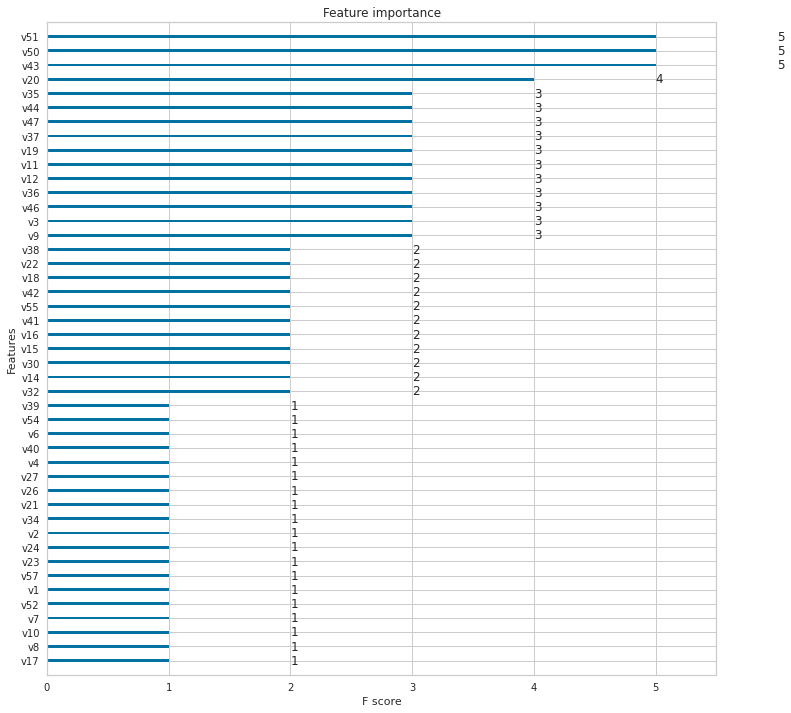

In [69]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(xgb_class, ax=ax)
fig.savefig("images/classification_xgboost.png", dpi=300)

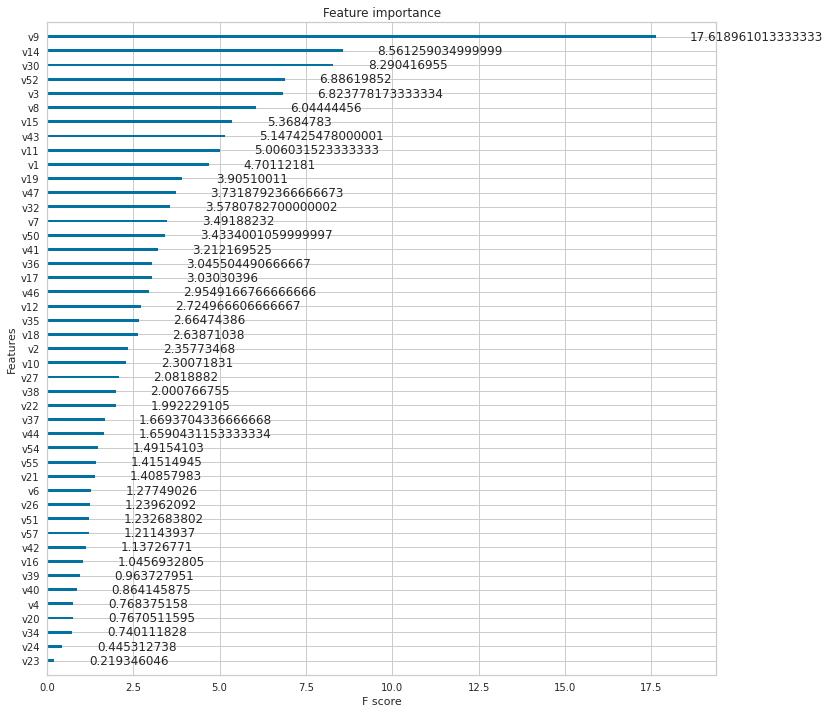

In [70]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(xgb_class, ax=ax, importance_type="gain")
fig.savefig("images/classification_xgboost2.png", dpi=300)

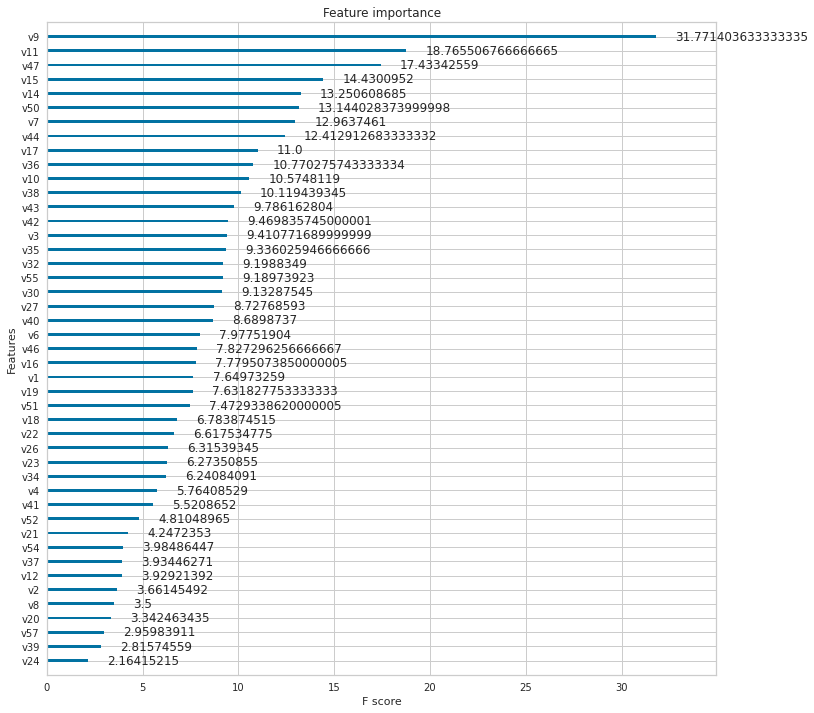

In [71]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(xgb_class, ax=ax, importance_type="cover")
fig.savefig("images/classification_xgboost3.png", dpi=300)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


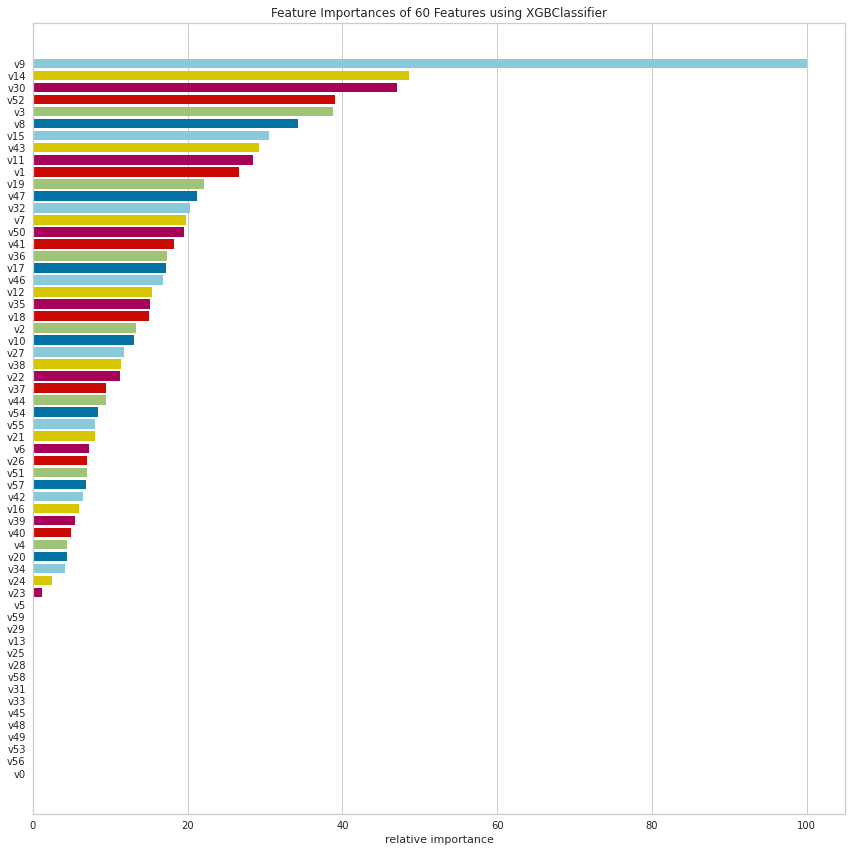

In [72]:
# We can plot this in Yellowbrick, which normalizes the values
fig, ax = plt.subplots(figsize=(12, 12))
fi_viz = FeatureImportances(xgb_class)
fi_viz.fit(X, y)
fi_viz.poof()
fig.savefig("images/classification_xgboost4.png", dpi=300)

In [73]:
# XGBoost provides both a textual representation of the trees and a graphical one. Here is the text representation
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[v9<0.163150012] yes=1,no=2,missing=1
	1:[v3<0.0582499988] yes=3,no=4,missing=3
		3:[v43<0.393100023] yes=7,no=8,missing=7
			7:[v17<0.809399962] yes=15,no=16,missing=15
				15:leaf=0.545454562
				16:leaf=-0
			8:leaf=-0.150000006
		4:[v32<0.539600015] yes=9,no=10,missing=9
			9:leaf=-0.428571463
			10:leaf=0.150000006
	2:[v14<0.561650038] yes=5,no=6,missing=5
		5:[v46<0.0610999987] yes=11,no=12,missing=11
			11:leaf=0.0545454584
			12:[v36<0.479999989] yes=17,no=18,missing=17
				17:leaf=-0.547826111
				18:[v8<0.24440001] yes=19,no=20,missing=19
					19:leaf=0.24000001
					20:leaf=-0.400000036
		6:[v30<0.367399991] yes=13,no=14,missing=13
			13:leaf=-0.300000012
			14:leaf=0.450000018



The value in the leaf is the score for class 1. It can be converted into a probability using the logistic function. If the decisions fell through to leaf 15, the probability of class 1 is 63%. This is the score from a single tree. If our model had 100 trees, you would sum up each leaf value and get the probability with the logistic function.

In [74]:
# score from first tree leaf 15
1 / (1 + np.exp(-1 * 0.545454562))

0.6330803730981698

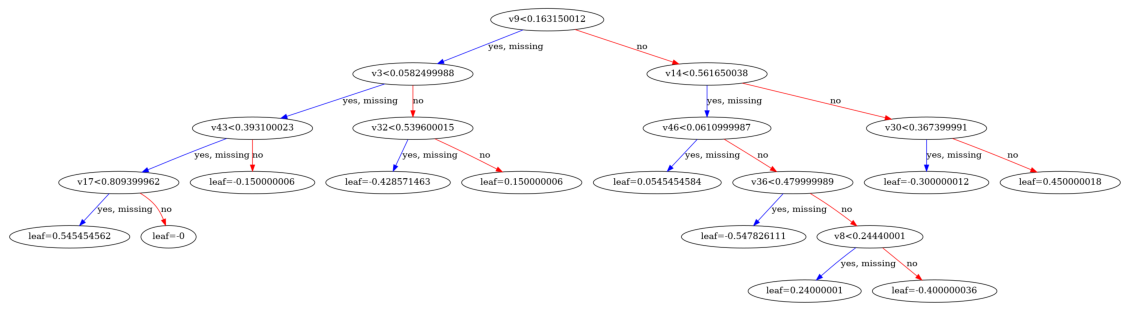

In [75]:
# Here is the graphical version of the first tree in the model
fig, ax = plt.subplots(figsize=(20, 16))
xgb.plot_tree(xgb_class, ax=ax, num_trees=0)
fig.savefig("images/classification_xgboost5.png", dpi=300)

The `xgbfir` package is a library built on top of XGBoost. This library gives various measures about feature importance. What is unique is that it provides these measures about the columns, and also pairs of columns, so you can see the interactions. In addition, you can get information about triplets (three-column) interactions.

The interface is simply an export to a spreadsheet, so we will use pandas to read them back in. Here is the column importance.

In [78]:
import xgbfir

xgbfir.saveXgbFI(xgb_class,  feature_names=X.columns, OutputXlsxFile="misc/xgbfir.xlsx",)
pd.read_excel("misc/xgbfir.xlsx").head(3).T

,0,1,2
Interaction,v9,v43,v3
Gain,52.8569,25.7371,20.4713
FScore,3,5,3
wFScore,3,1.65618,1.05011
Average wFScore,1,0.331236,0.350038
Average Gain,17.619,5.14743,6.82378
Expected Gain,52.8569,9.71022,8.42945
Gain Rank,1,2,3
FScore Rank,5,1,6
wFScore Rank,2,8,11


In [ ]:
- **Runtime efficiency:** 
- **Preprocess data:** 
- **Prevent overfitting:** 
- **Interpret results:** 